# 2023 Deep Learning Course Challenge (partnership with Dreem)

### Imports

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, accuracy_score, balanced_accuracy_score
import logging
from tsflex.features.logger import logger
logger.setLevel(level=logging.ERROR)
from tsflex.processing.logger import logger
logger.setLevel(level=logging.ERROR)
import antropy as ant
import scipy.stats as ss
from yasa import bandpower
from tsflex.features import (
    FeatureCollection,
    FuncWrapper,
    MultipleFeatureDescriptors,
    FuncWrapper,
)
from tsflex.features.integrations import tsfresh_settings_wrapper

In [2]:
from data_manager import *
from preprocessing import *
from training import *

### Load data

In [9]:
train_folder = os.path.join(os.getcwd(), "data", "train_records")
freqEEG = 250
freqACC = 50
axes_names = ["x", "y", "z"]

data_records = load_data(train_folder, freqEEG, freqACC, axes_names)

Visualization of data (example with column 0 = 1st EEG channel):

In [15]:
data_records["record_0.npy"][0].head()

1970-01-01 00:00:00.000     -90.350815
1970-01-01 00:00:00.004    5377.315430
1970-01-01 00:00:00.008    8868.837891
1970-01-01 00:00:00.012    9513.023438
1970-01-01 00:00:00.016    8361.289062
Freq: 4L, Name: EEG1, dtype: float64

We can see that the signal contains some outliers that need to be filtered out:

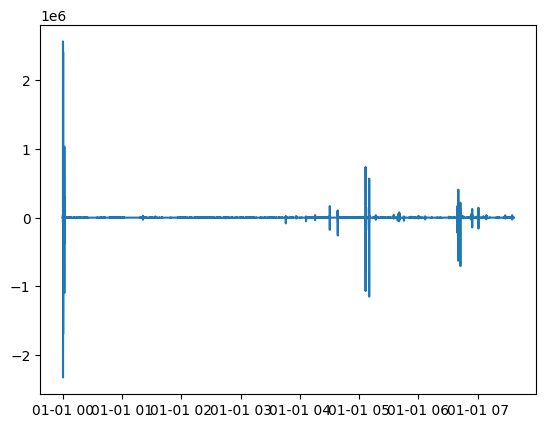

In [16]:
plt.plot(data_records["record_0.npy"][0].index, data_records["record_0.npy"][0].values)

# Preprocessing

The first step is to preprocess the data. According to [1], meaningful EEG frequencies of sleep-wave patterns are between 0.40 Hz and 30 Hz. Plus, at higher frequencies the signal is contaminated by noise, like power line noise occuring at 50Hz. As a result, we will use a band-pass to filter the data to remove:
- power line noise / other types of high frequency noise,
- heartbeat artifacts,
- breathing artifacts,
- low frequency noise (slow movements, etc).


[1] Malhotra, A., Younes, M., Kuna, S.T., Benca, R., Kushida, C.A., Walsh, J., Hanlon, A., Staley, B., Pack, A.I., Pien, G.W.: Performance of an automated polysomnography scoring system versus computer assisted manual scoring. Sleep 36(4), 573{582} (2013)

In [ ]:
data_records = filter_data(data_records, freqEEG, freqACC, axes_names)

Sanity check

In [ ]:
data_records["record_0.npy"][0]

1970-01-01 00:00:00.000      -0.236370
1970-01-01 00:00:00.004      12.277020
1970-01-01 00:00:00.008     123.519403
1970-01-01 00:00:00.012     559.918243
1970-01-01 00:00:00.016    1610.579699
                              ...     
1970-01-01 07:36:29.980     318.250521
1970-01-01 07:36:29.984     329.064055
1970-01-01 07:36:29.988     346.060601
1970-01-01 07:36:29.992     369.273281
1970-01-01 07:36:29.996     398.204584
Freq: 4L, Name: EEG1, Length: 6847500, dtype: float64

# Now we aim to extract features

These features consist of both time-domain and frequency-domain functions. In a nutshell, we will use the tsfresh package to compute basic statistics (mean, variance, skewness and kurtosis) of short periods of time called windows. Basically, each epoch will be split into many windows of a given length (30s, 1min or 1min30s). The fourier entropy and the binned entropy parameters are also changed. Thus, each statistic is computed several times, for each window length and each entropy parameter. Since the EEG signals are noisy and difficult to acquire, such feature extraction process allow us to perform some kind of data augmentation.

For more details, see Table 1 of https://arxiv.org/pdf/2207.07753v3.pdf

In [25]:
# Create the collection of tsfresh features to extract

tsfresh_settings = {
    "fft_aggregated": [
        {"aggtype": "centroid"},
        {"aggtype": "variance"},
        {"aggtype": "skew"},
        {"aggtype": "kurtosis"},
    ],
    "fourier_entropy": [
        {"bins": 2},
        {"bins": 3},
        {"bins": 5},
        {"bins": 10},
        {"bins": 30},
        {"bins": 60},
        {"bins": 100},
    ],
    "binned_entropy": [
        {"max_bins": 5},
        {"max_bins": 10},
        {"max_bins": 30},
        {"max_bins": 60},
    ],
}

tsfresh_settings

{'fft_aggregated': [{'aggtype': 'centroid'},
  {'aggtype': 'variance'},
  {'aggtype': 'skew'},
  {'aggtype': 'kurtosis'}],
 'fourier_entropy': [{'bins': 2},
  {'bins': 3},
  {'bins': 5},
  {'bins': 10},
  {'bins': 30},
  {'bins': 60},
  {'bins': 100}],
 'binned_entropy': [{'max_bins': 5},
  {'max_bins': 10},
  {'max_bins': 30},
  {'max_bins': 60}]}

In [26]:
bands = [
    (0.4, 1, "sdelta"),
    (1, 4, "fdelta"),
    (4, 8, "theta"),
    (8, 12, "alpha"),
    (12, 16, "sigma"),
    (16, 30, "beta"),
]
bandpowers_ouputs = [b[2] for b in bands] + ["TotalAbsPow"]

time_funcs = [
    np.std,
    ss.iqr,
    ss.skew,
    ss.kurtosis,
    ant.num_zerocross,
    FuncWrapper(
        ant.hjorth_params, output_names=["horth_mobility", "hjorth_complexity"]
    ),
    wrapped_higuchi_fd,
    ant.petrosian_fd,
    ant.perm_entropy,
] + tsfresh_settings_wrapper(tsfresh_settings)

freq_funcs = [
    FuncWrapper(wrapped_bandpowers, sf=freqEEG, bands=bands, output_names=bandpowers_ouputs)
]

time_feats = MultipleFeatureDescriptors(
    time_funcs,
    [f"EEG{i}" for i in range(1,6)],
    windows=["30s", "60s", "90s"],
    strides="30s",
)
freq_feats = MultipleFeatureDescriptors(
    freq_funcs,
    [f"EEG{i}" for i in range(1,6)],
    windows=["30s", "60s", "90s"],
    strides="30s",
)
acc_feats = MultipleFeatureDescriptors(
    time_funcs,
    [f"Accelerometer_{axes_names[i]}" for i in range(3)],
    windows=["30s", "60s", "90s"],
    strides="30s",
)
acc_feats_h = MultipleFeatureDescriptors(
    time_funcs,
    [f"Accelerometer_h_{axes_names[i]}" for i in range(3)],
    windows=["30s", "60s", "90s"],
    strides="30s",
)

feature_collection = FeatureCollection([time_feats, freq_feats, acc_feats, acc_feats_h])

In [ ]:
data_records = compute_features(data_records, feature_collection)

In [12]:
data_records['record_0.npy']

,Accelerometer_h_x__binned_entropy_{'max_bins': 10}__w=1m,Accelerometer_h_x__binned_entropy_{'max_bins': 10}__w=1m30s,Accelerometer_h_x__binned_entropy_{'max_bins': 10}__w=30s,Accelerometer_h_x__binned_entropy_{'max_bins': 30}__w=1m,Accelerometer_h_x__binned_entropy_{'max_bins': 30}__w=1m30s,Accelerometer_h_x__binned_entropy_{'max_bins': 30}__w=30s,Accelerometer_h_x__binned_entropy_{'max_bins': 5}__w=1m,Accelerometer_h_x__binned_entropy_{'max_bins': 5}__w=1m30s,Accelerometer_h_x__binned_entropy_{'max_bins': 5}__w=30s,Accelerometer_h_x__binned_entropy_{'max_bins': 60}__w=1m,...,EEG5__skew__w=30s,EEG5__std__w=1m,EEG5__std__w=1m30s,EEG5__std__w=30s,EEG5__theta__w=1m,EEG5__theta__w=1m30s,EEG5__theta__w=30s,EEG5__wrapped_higuchi_fd__w=1m,EEG5__wrapped_higuchi_fd__w=1m30s,EEG5__wrapped_higuchi_fd__w=30s
1970-01-01 00:00:30,NaN,NaN,1.187073,NaN,NaN,2.182294,NaN,NaN,0.797974,NaN,...,-2.108530,NaN,NaN,222924.656250,NaN,NaN,0.005475,NaN,NaN,1.007979
1970-01-01 00:01:00,1.078662,NaN,1.786564,2.059463,NaN,2.694881,0.677025,NaN,1.150120,2.697820,...,0.467172,159524.265625,NaN,34645.386719,0.003530,NaN,0.001607,1.008178,NaN,1.010534
1970-01-01 00:01:30,1.146842,0.834576,1.250716,1.671748,1.632353,2.284831,0.722892,0.529528,0.915670,2.002607,...,0.501532,24499.357422,130251.093750,247.718628,0.013782,0.001638,0.044105,1.022603,1.009903,1.359775
1970-01-01 00:02:00,1.082307,1.143560,1.730890,1.710117,1.767439,2.657173,0.753461,0.650777,1.185644,2.014962,...,1.196585,79819.312500,68172.921875,112881.281250,0.030485,0.017753,0.074519,1.015034,1.013610,1.007986
1970-01-01 00:02:30,1.082307,0.797549,2.072917,1.641334,1.255931,3.143227,0.753461,0.560303,1.393603,1.940655,...,0.058531,79819.132812,65172.203125,59.367050,0.060693,0.045105,0.049952,1.013372,1.020055,1.411472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 07:34:00,1.087663,0.966031,1.304115,2.035305,1.900055,2.319144,0.650090,0.552539,0.807369,2.702654,...,-0.159326,24.369497,21.532112,12.024343,0.180902,0.164019,0.198495,1.192701,1.191309,1.200267
1970-01-01 07:34:30,1.081391,0.890757,2.068486,2.069585,1.845492,3.135562,0.619425,0.504919,1.394686,2.750043,...,-0.024202,12.386676,21.213255,12.738199,0.191361,0.184859,0.166799,1.195420,1.191993,1.190881
1970-01-01 07:35:00,0.897794,0.659441,1.456610,1.390132,1.035569,2.292065,0.619233,0.458783,0.988404,1.625080,...,7.397927,14437.676758,11788.324219,20417.910156,0.162215,0.191939,0.028869,1.041588,1.042879,1.040196
1970-01-01 07:35:30,1.198929,0.893045,1.051215,1.943414,1.446853,1.439770,0.821045,0.617854,0.677851,2.309256,...,1.100029,14462.291016,11808.413086,1190.597900,0.138171,0.151349,0.128065,1.045619,1.046712,1.109222


Add the labels, the record id and the patient id to the data

In [13]:
data_records = add_labels(data_records, train_folder)

In [14]:
data_records["record_0.npy"]

,Accelerometer_h_x__binned_entropy_{'max_bins': 10}__w=1m,Accelerometer_h_x__binned_entropy_{'max_bins': 10}__w=1m30s,Accelerometer_h_x__binned_entropy_{'max_bins': 10}__w=30s,Accelerometer_h_x__binned_entropy_{'max_bins': 30}__w=1m,Accelerometer_h_x__binned_entropy_{'max_bins': 30}__w=1m30s,Accelerometer_h_x__binned_entropy_{'max_bins': 30}__w=30s,Accelerometer_h_x__binned_entropy_{'max_bins': 5}__w=1m,Accelerometer_h_x__binned_entropy_{'max_bins': 5}__w=1m30s,Accelerometer_h_x__binned_entropy_{'max_bins': 5}__w=30s,Accelerometer_h_x__binned_entropy_{'max_bins': 60}__w=1m,...,EEG5__std__w=1m,EEG5__std__w=1m30s,EEG5__std__w=30s,EEG5__theta__w=1m,EEG5__theta__w=1m30s,EEG5__theta__w=30s,EEG5__wrapped_higuchi_fd__w=1m,EEG5__wrapped_higuchi_fd__w=1m30s,EEG5__wrapped_higuchi_fd__w=30s,target
1970-01-01 00:00:30,NaN,NaN,1.187073,NaN,NaN,2.182294,NaN,NaN,0.797974,NaN,...,NaN,NaN,222924.656250,NaN,NaN,0.005475,NaN,NaN,1.007979,0
1970-01-01 00:01:00,1.078662,NaN,1.786564,2.059463,NaN,2.694881,0.677025,NaN,1.150120,2.697820,...,159524.265625,NaN,34645.386719,0.003530,NaN,0.001607,1.008178,NaN,1.010534,0
1970-01-01 00:01:30,1.146842,0.834576,1.250716,1.671748,1.632353,2.284831,0.722892,0.529528,0.915670,2.002607,...,24499.357422,130251.093750,247.718628,0.013782,0.001638,0.044105,1.022603,1.009903,1.359775,0
1970-01-01 00:02:00,1.082307,1.143560,1.730890,1.710117,1.767439,2.657173,0.753461,0.650777,1.185644,2.014962,...,79819.312500,68172.921875,112881.281250,0.030485,0.017753,0.074519,1.015034,1.013610,1.007986,0
1970-01-01 00:02:30,1.082307,0.797549,2.072917,1.641334,1.255931,3.143227,0.753461,0.560303,1.393603,1.940655,...,79819.132812,65172.203125,59.367050,0.060693,0.045105,0.049952,1.013372,1.020055,1.411472,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 07:34:00,1.087663,0.966031,1.304115,2.035305,1.900055,2.319144,0.650090,0.552539,0.807369,2.702654,...,24.369497,21.532112,12.024343,0.180902,0.164019,0.198495,1.192701,1.191309,1.200267,0
1970-01-01 07:34:30,1.081391,0.890757,2.068486,2.069585,1.845492,3.135562,0.619425,0.504919,1.394686,2.750043,...,12.386676,21.213255,12.738199,0.191361,0.184859,0.166799,1.195420,1.191993,1.190881,0
1970-01-01 07:35:00,0.897794,0.659441,1.456610,1.390132,1.035569,2.292065,0.619233,0.458783,0.988404,1.625080,...,14437.676758,11788.324219,20417.910156,0.162215,0.191939,0.028869,1.041588,1.042879,1.040196,0
1970-01-01 07:35:30,1.198929,0.893045,1.051215,1.943414,1.446853,1.439770,0.821045,0.617854,0.677851,2.309256,...,14462.291016,11808.413086,1190.597900,0.138171,0.151349,0.128065,1.045619,1.046712,1.109222,0


In [15]:
df_feats = add_record_and_patient_ids(data_records)
df_feats

,Accelerometer_h_x__binned_entropy_{'max_bins': 10}__w=1m,Accelerometer_h_x__binned_entropy_{'max_bins': 10}__w=1m30s,Accelerometer_h_x__binned_entropy_{'max_bins': 10}__w=30s,Accelerometer_h_x__binned_entropy_{'max_bins': 30}__w=1m,Accelerometer_h_x__binned_entropy_{'max_bins': 30}__w=1m30s,Accelerometer_h_x__binned_entropy_{'max_bins': 30}__w=30s,Accelerometer_h_x__binned_entropy_{'max_bins': 5}__w=1m,Accelerometer_h_x__binned_entropy_{'max_bins': 5}__w=1m30s,Accelerometer_h_x__binned_entropy_{'max_bins': 5}__w=30s,Accelerometer_h_x__binned_entropy_{'max_bins': 60}__w=1m,...,EEG5__std__w=30s,EEG5__theta__w=1m,EEG5__theta__w=1m30s,EEG5__theta__w=30s,EEG5__wrapped_higuchi_fd__w=1m,EEG5__wrapped_higuchi_fd__w=1m30s,EEG5__wrapped_higuchi_fd__w=30s,target,record,patient_id
1970-01-01 00:00:30,NaN,NaN,1.187073,NaN,NaN,2.182294,NaN,NaN,0.797974,NaN,...,222924.656250,NaN,NaN,0.005475,NaN,NaN,1.007979,0,record_0.npy,0
1970-01-01 00:01:00,1.078662,NaN,1.786564,2.059463,NaN,2.694881,0.677025,NaN,1.150120,2.697820,...,34645.386719,0.003530,NaN,0.001607,1.008178,NaN,1.010534,0,record_0.npy,0
1970-01-01 00:01:30,1.146842,0.834576,1.250716,1.671748,1.632353,2.284831,0.722892,0.529528,0.915670,2.002607,...,247.718628,0.013782,0.001638,0.044105,1.022603,1.009903,1.359775,0,record_0.npy,0
1970-01-01 00:02:00,1.082307,1.143560,1.730890,1.710117,1.767439,2.657173,0.753461,0.650777,1.185644,2.014962,...,112881.281250,0.030485,0.017753,0.074519,1.015034,1.013610,1.007986,0,record_0.npy,0
1970-01-01 00:02:30,1.082307,0.797549,2.072917,1.641334,1.255931,3.143227,0.753461,0.560303,1.393603,1.940655,...,59.367050,0.060693,0.045105,0.049952,1.013372,1.020055,1.411472,0,record_0.npy,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 08:31:30,2.135401,0.990252,2.153195,3.210788,1.747465,3.221069,1.484674,0.305918,1.480668,3.898566,...,8.352031,0.119484,0.125893,0.143402,1.182732,1.179987,1.191846,0,record_6.npy,6
1970-01-01 08:32:00,1.906256,1.905235,1.849178,2.984692,2.985321,2.915431,1.257485,1.243551,1.226885,3.669136,...,7.714387,0.157155,0.131442,0.143057,1.194298,1.187279,1.196360,0,record_6.npy,6
1970-01-01 08:32:30,1.133428,0.852392,1.692719,1.810792,1.343048,2.734230,0.667544,0.498222,1.042578,2.183909,...,727.954895,0.163613,0.156827,0.012245,1.069585,1.080314,1.054833,0,record_6.npy,6
1970-01-01 08:33:00,1.460106,1.123790,1.323048,2.396222,1.838660,2.060873,0.879913,0.668584,0.882571,2.970178,...,33.551552,0.019832,0.061894,0.024609,1.071110,1.082580,1.186453,0,record_6.npy,6


### EEG bands feature extraction

Now we compute additional features related to the spectral power contained in some well-defined frequency bands. Indeed, when manipulating EEG data, some frequencies are more likely to appear depending on the consciousness state of the patient. For instance, if they are drowsy, the EEG signal is likely to contain oscillations in the range of 8-12Hz called alpha waves. A way to monitor these oscillations (and thus to get information about the night stage in which the patient is) is to compute the spectral power contained in the alpha, beta, sdelta, fdelta, sigma and theta bands and the ratios of these quantities.

As above, we compute these features on windows of different lengths (30s, 1min and 1min30s).

In [32]:
bands = ["alpha", "beta", "sdelta", "fdelta", "sigma", "theta"]
df_feats = add_eeg_bands_features(df_feats, bands)

In [33]:
# Sanity check; df_feats shape should now be (6168, 1008)
df_feats.shape

(6168, 1008)

In [34]:
# Add the 30s features from the minute before and the minute after the epoch (= current sample of 30s) to the epoch
df_feats = add_shifted_feats(df_feats)

In [35]:
# Sanity check; df_feats shape should now be (6168, 2348)
df_feats.shape

(6168, 2348)

In [7]:
df_feats.to_csv("features.csv")

## Class distribution and train/val split

Classes 0 and 1 (corresponding to paradoxal sleep/deep sleep) are not very well representated in the training dataset, because these sleep stages are quite short over one whole night. That's why we upsampled the data by creating overlapping windows of several lengths; it should allow us to have an improved representation of our data (hopefully).

<Axes: >

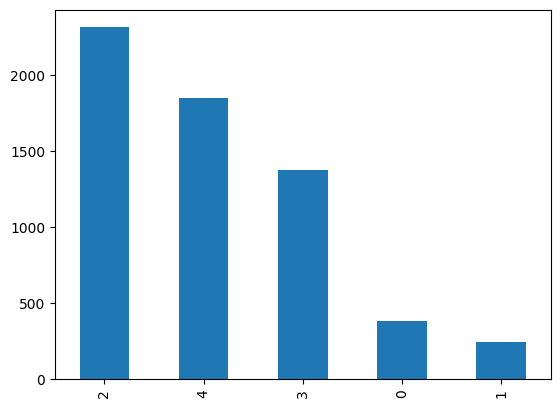

In [18]:
df_feats["target"].value_counts().plot(kind="bar")

**Seperate in training and validation set**

Run this cell if you want to load the features computed earlier.

In [6]:
df_feats = pd.read_csv("features.csv", index_col=0)

We split the labelled data into train/val datasets. Since we have only a few records and that each of them carry subject-specific features, we chose to use one record (= one person) only for the validation set. That way, the model can still learn from different persons and it should not overfit.

In [7]:
rd.seed(1234)
records_list = list(data_records)

training_record,val_records = datasets(records_list)


print('Training records: ',training_record)
print('Validation records: ', val_records)
print('records:', records_list)

Training records:  ['record_1.npy', 'record_2.npy', 'record_5.npy', 'record_4.npy', 'record_0.npy', 'record_3.npy']
Validation records:  ['record_6.npy']
records: ['record_1.npy', 'record_2.npy', 'record_5.npy', 'record_4.npy', 'record_0.npy', 'record_3.npy', 'record_6.npy']


In [8]:
df_train = df_feats[df_feats["record"].isin(training_record)]
df_val = df_feats[df_feats["record"].isin(val_records)]

Let us have a look at the size of each dataset:

In [9]:
print(df_train.shape)
print(df_val.shape)

(5141, 2348)
(1027, 2348)


# Train CatBoost model

This model was chosen because models based on decision trees are known to be particularly efficient with EEG data. Other models like Random Forest or XGBoost were also tested, and they had either lower or similar peformances compared to catboost.

To conduct the hyperparameter search, we chose to use Optuna. It is a Python library that performs hyperparameter search based on optimization algorithms and heuristics, which make it more efficient than a simple Grid Search from sklearn for instance. 

In `training.py`, we defined an objective function in which we test a new model. Its performance is assessed using f1-score (which is the main metric used for this challenge). At each new trial, Optuna chooses a new set of hyperparameters to maximize catboost's f1-score. Basically, it takes advantage of values that got good results during the past trials, but it also explores the hyperparameter space to avoid being stuck at a local extremum.

Finally, if you do not want to run catboost on GPU, comment the `GPU` and the `device` arguments in catboostClassifier definition, in `training.py`.

In [11]:
import optuna

skip_cols = ["record", "target", "patient_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]

study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial, df_feats, feat_cols, records_list), n_trials=100)

study.best_params

[I 2023-08-16 09:39:47,019] A new study created in memory with name: no-name-10503679-d13d-4e9f-b3ab-4a053c40ec3a
[I 2023-08-16 09:39:53,090] Trial 0 finished with value: 0.8731345406003665 and parameters: {'learning_rate': 0.015278172231248324, 'depth': 2, 'min_data_in_leaf': 26}. Best is trial 0 with value: 0.8731345406003665.
[I 2023-08-16 09:41:23,112] Trial 1 finished with value: 0.8786782727295082 and parameters: {'learning_rate': 0.049667563101927305, 'depth': 8, 'min_data_in_leaf': 19}. Best is trial 1 with value: 0.8786782727295082.
[I 2023-08-16 09:42:25,978] Trial 2 finished with value: 0.7760567093804108 and parameters: {'learning_rate': 0.0036679637795224798, 'depth': 7, 'min_data_in_leaf': 100}. Best is trial 1 with value: 0.8786782727295082.
[I 2023-08-16 09:42:30,371] Trial 3 finished with value: 0.828515407397106 and parameters: {'learning_rate': 0.03379774612024326, 'depth': 2, 'min_data_in_leaf': 25}. Best is trial 1 with value: 0.8786782727295082.
[I 2023-08-16 09:4

{'learning_rate': 0.026516612207777235, 'depth': 6, 'min_data_in_leaf': 47}

Save best parameters in json file.

In [12]:
with open("params.json", "w") as outfile:
    json.dump(study.best_params, outfile)

# Submit predictions

In [ ]:
df_feats = pd.read_csv("features.csv")

In [ ]:
# Sanity check
df_feats

In [13]:
skip_cols = ["record", "target", "patient_id"]
feat_cols = [c for c in df_feats.columns if c not in skip_cols]

Now, we train a catboost classifier using the set of parameters that lead to the best results during the Optuna study.

In [17]:
from catboost import CatBoostClassifier

training_record,val_records = datasets(records_list)
df_train = df_feats[df_feats["record"].isin(training_record)]
df_val = df_feats[df_feats["record"].isin(val_records)]

X_train = np.array(df_train[feat_cols])
y_train = np.array(df_train["target"])
X_val = np.array(df_val[feat_cols])
y_val = np.array(df_val["target"])

eval_set = [(X_train, y_train), (X_val, y_val)]

params = study.best_params

model = CatBoostClassifier(**params)
model.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=20)

0:	learn: 1.5501604	test: 1.5501604	test1: 1.5613745	best: 1.5613745 (0)	total: 412ms	remaining: 6m 51s
1:	learn: 1.5009316	test: 1.5009316	test1: 1.5367227	best: 1.5367227 (1)	total: 814ms	remaining: 6m 46s
2:	learn: 1.4517795	test: 1.4517795	test1: 1.4956774	best: 1.4956774 (2)	total: 1.14s	remaining: 6m 19s
3:	learn: 1.4066827	test: 1.4066827	test1: 1.4609621	best: 1.4609621 (3)	total: 1.42s	remaining: 5m 54s
4:	learn: 1.3636994	test: 1.3636994	test1: 1.4261157	best: 1.4261157 (4)	total: 1.72s	remaining: 5m 41s
5:	learn: 1.3246907	test: 1.3246907	test1: 1.3987692	best: 1.3987692 (5)	total: 2s	remaining: 5m 32s
6:	learn: 1.2896998	test: 1.2896998	test1: 1.3741522	best: 1.3741522 (6)	total: 2.29s	remaining: 5m 25s
7:	learn: 1.2571040	test: 1.2571040	test1: 1.3527858	best: 1.3527858 (7)	total: 2.62s	remaining: 5m 25s
8:	learn: 1.2260650	test: 1.2260650	test1: 1.3310933	best: 1.3310933 (8)	total: 2.94s	remaining: 5m 24s
9:	learn: 1.1966083	test: 1.1966083	test1: 1.3073480	best: 1.307348

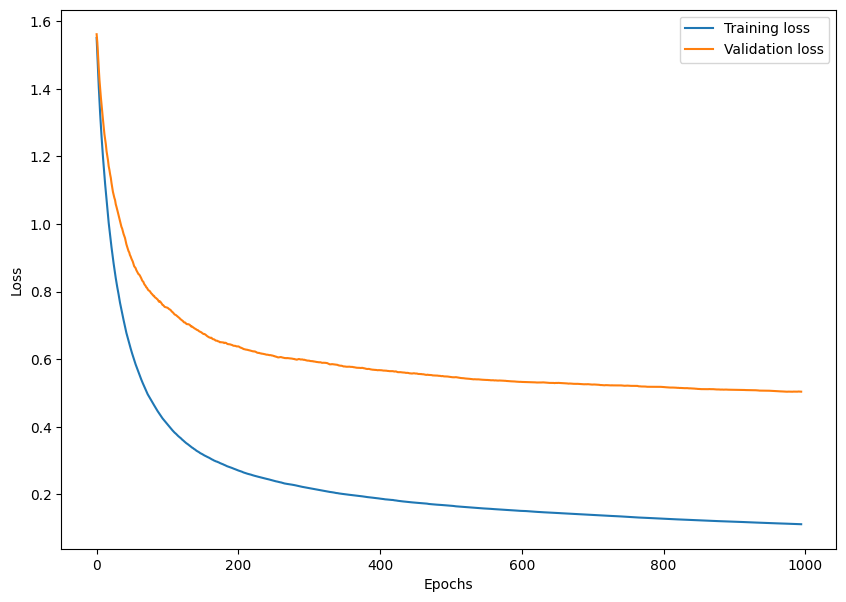

In [44]:
#learning curves
results = model.get_evals_result()

plt.figure(figsize=(10,7))
plt.plot(results['learn']['MultiClass'], label="Training loss")
plt.plot(results['validation_1']['MultiClass'], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

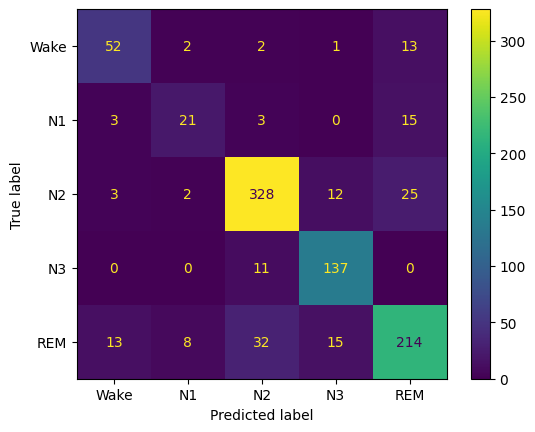

In [18]:
# confusion matrix
y_pred = model.predict(X_val)
cm = confusion_matrix(y_val, y_pred, labels = [0, 1, 2, 3, 4])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Wake','N1','N2','N3','REM'])
disp.plot()

In [22]:
# Metrics
print("f1-score:", f1_score(y_val, y_pred, average ='macro'))
print("Accuracy:", accuracy_score(y_val, y_pred, normalize=True))
print("Balanced Accuracy:", balanced_accuracy_score(y_val, y_pred))

f1-score: 0.7663887706543591
Accuracy: 0.8245614035087719
Balanced Accuracy: 0.762776910649251


In [33]:
model.save_model("final_model")

### Features of the test dataset

Let's compute all the necessary features using the test dataset.

In [ ]:
# Loading data in Series
from collections import defaultdict

test_folder = os.path.join(os.getcwd(), "data", "test_records")

data_records_test = load_data(test_folder, freqEEG, freqACC, axes_names)
data_records_test = filter_data(data_records_test, freqEEG, freqACC, axes_names)
data_records_test = compute_features(data_records_test, feature_collection)

df_feats_test = add_record_and_patient_ids(data_records_test)
df_feats_test = add_eeg_bands_features(df_feats_test, bands)
df_feats_test = add_shifted_feats(df_feats_test)

In [ ]:
df_feats_test.to_csv("features_test.csv")

### Predictions

We are going to create predictions file with test dataset. Load the test features file if needed with the next cell, otherwise just skip it.

In [29]:
df_feats_test = pd.read_csv("features_test.csv")

In [ ]:
predictions_all_records = []
skip_cols = ["record", "target", "patient_id"]
feat_cols = [c for c in df_feats_test.columns if c not in skip_cols]

for record in os.listdir("data/test_records"):
    predictions = []
    #preds = model_xgb.predict(df_feats[df_feats["record"] == record][feat_cols])
    preds = model.predict(df_feats_test[df_feats_test["record"] == record][feat_cols])

    for i, pred in enumerate(preds):
        predictions.append({"identifier": int(record[-5]) * 10000 + i,'target':pred[0]})
    
    predictions.append({"identifier": int(record[-5]) * 10000 + i + 1,'target': pred[0]})
    predictions_all_records.append(pd.DataFrame(predictions))

    
predictions_all_records = pd.concat(predictions_all_records).reset_index(drop = True)

It's not surprising to see zeros only on the first lines of `predictions_all_records` as the records start when the participant is awake (class 0).

In [35]:
predictions_all_records.head()

,identifier,target
0,70000,0
1,70001,0
2,70002,0
3,70003,0
4,70004,0


In [36]:
predictions_all_records.to_csv('predictions.csv',index = None)
print('Done')

Done
